<a href="https://colab.research.google.com/github/l2lal/MachineLearning/blob/master/lal_20572296.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
#RESOURCES: 
#1. https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
#2. https://www.kaggle.com/cokastefan/keras-resnet-50
#3. http://dev1-kimia.uwaterloo.ca:5678/data/tut7/notebook.html
#4. https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
#5. https://www.kaggle.com/tonypoe/keras-cnn-example
#6. https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.utils import np_utils
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.applications import ResNet50
import pandas as pd
tf.enable_eager_execution()


import os
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline



In [8]:
#Download and Unzip the Data
!wget http://dev1-kimia.uwaterloo.ca:5678/data/kaggle/data.zip
!ls
!unzip -o data.zip

# Load Data
X_train = np.load('train_x.npy')
X_test = np.load('test_x.npy')
y_train = np.load('train_label.npy')

# Get Classes
classes = np.unique(y_train)
class_dict = {cls: i for i, cls in enumerate(classes)}

X_ds = tf.data.Dataset.from_tensor_slices(X_train)
ds_iter = iter(X_ds)

# Read Labels
Y = [np.eye(len(classes))[class_dict[label]] for label in y_train]
Y_ds = tf.data.Dataset.from_tensor_slices(Y)
ds_iter = iter(Y_ds)

# Package Dataset Into Tuple
ds = tf.data.Dataset.zip((X_ds, Y_ds)).batch(32).repeat(100)
ds_iter = iter(ds)


--2019-04-09 04:56:52--  http://dev1-kimia.uwaterloo.ca:5678/data/kaggle/data.zip
Resolving dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)... 129.97.229.28
Connecting to dev1-kimia.uwaterloo.ca (dev1-kimia.uwaterloo.ca)|129.97.229.28|:5678... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126975279 (121M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 121.09M  58.3MB/s    in 2.1s    

2019-04-09 04:56:54 (58.3 MB/s) - ‘data.zip’ saved [126975279/126975279]

data.zip  sample_data
Archive:  data.zip
  inflating: train_x.npy             
  inflating: test_x.npy              
  inflating: sample_submission.csv   
  inflating: train_label.npy         


the number of training examples = 760
the number of classes = 20
Dimention of images = 168 x 308  
The number of occuranc of each class in the dataset = {0: 42, 1: 34, 2: 40, 3: 37, 4: 36, 5: 36, 6: 33, 7: 41, 8: 40, 9: 39, 10: 40, 11: 41, 12: 41, 13: 40, 14: 37, 15: 36, 16: 38, 17: 42, 18: 34, 19: 33}  



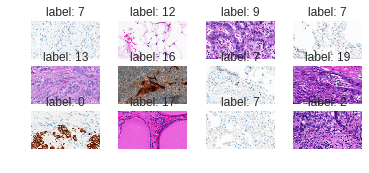

In [9]:
X_train = X_train.reshape(X_train.shape[0], 168, 308 , 3)
X_test = X_test.reshape(X_test.shape[0], 168, 308 , 3)

print("the number of training examples = %i" % X_train.shape[0])
print("the number of classes = %i" % len(np.unique(y_train)))
print("Dimention of images = {:d} x {:d}  ".format(X_train[1].shape[0],X_train[1].shape[1])  )

unique, count= np.unique(y_train, return_counts=True)
print("The number of occuranc of each class in the dataset = %s " % dict (zip(unique, count) ), "\n" )

images_and_labels = list(zip(X_train,  y_train))

for index, (image, label) in enumerate(images_and_labels[:12]):
    plt.subplot(5, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('label: %i' % label )
    
#number of samples in each class is very close, so it is balanced, so we can use accuracy metric
# Learned this from #5
#5. https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

In [0]:
# Create Model
model1 = keras.Sequential()
model1.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model1.add(Flatten()) 
model1.add(BatchNormalization())
model1.add(Dense(2048, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(1024, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dense(len(classes), activation='softmax'))
model1.layers[0].trainable = False

In [11]:
model1.summary()
optimizer = tf.train.AdamOptimizer()
model1.compile(optimizer=optimizer, loss=tf.losses.softmax_cross_entropy, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 1024)              4096      
__________

In [12]:
# Train the model with training data, ds
model1.fit( 
    ds,
    steps_per_epoch=100,
    epochs=10,
    verbose = 1) 

Epoch 1/10
Instructions for updating:
Use tf.cast instead.
100/100 [==============================] - 40s 396ms/step - loss: 2.1544 - acc: 0.9258
Epoch 2/10
100/100 [==============================] - 31s 310ms/step - loss: 2.0886 - acc: 0.9896
Epoch 3/10
100/100 [==============================] - 31s 310ms/step - loss: 2.0844 - acc: 0.9937
Epoch 4/10
100/100 [==============================] - 31s 310ms/step - loss: 2.0838 - acc: 0.9943
Epoch 5/10
100/100 [==============================] - 31s 310ms/step - loss: 2.0832 - acc: 0.9949
Epoch 6/10
100/100 [==============================] - 31s 309ms/step - loss: 2.0832 - acc: 0.9949
Epoch 7/10
100/100 [==============================] - 31s 308ms/step - loss: 2.0829 - acc: 0.9953
Epoch 8/10
100/100 [==============================] - 31s 309ms/step - loss: 2.0819 - acc: 0.9962
Epoch 9/10
100/100 [==============================] - 31s 309ms/step - loss: 2.0819 - acc: 0.9962
Epoch 10/10
100/100 [==============================] - 31s 309ms/step 

In [0]:
test_prediction = model1.predict(X_test)

# Save to a CSV: https://stackoverflow.com/questions/34010106/python-open-and-write-to-a-txt-file
with open('20572296_l2lal.csv', 'w') as f:
    f.write("Id" + "," + "Predicted" + '\n')
    for i in range(len(X_test)):
        f.write(str(i) + "," + str(np.argmax(test_prediction[i])) + '\n')